## Load libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import reaction_models as rxn
import plateau_analysis_fxns as paf
import itertools
from matplotlib.ticker import FormatStrFormatter

## Load simple physics parameters

In [2]:
sp_params = pd.read_csv('fitted_parameters_simple_physics_master.csv', index_col = 0)
display(sp_params)

,case,A1,A2,E1,E2
0,1,72.448290,49.507804,6.935788,12.492344
1,2,76.600171,10.396757,7.230669,7.513692
2,3,139.553241,88.739652,9.168945,14.244120
3,4,128.446729,31.224946,8.829378,11.261605
4,5,123.821545,5.535530,8.626742,5.943396
5,6,124.860947,107.160563,8.891237,14.778025
6,7,89.285271,27.945122,7.883856,10.946193
7,8,107.241241,44.968585,8.224972,12.476900
8,9,197.867993,4.666031,9.897156,6.461187
9,10,62.698517,183.592116,6.550067,16.606276


## Load training data control variables

In [3]:
# extract training data for each case study

cwd = os.getcwd()
path = os.path.join(cwd,'training_data_small_noise_full_physics_2')

csv_files = glob.glob(os.path.join(path,"*.csv"))
dict = {}

# loop over the list of csv files
for f in csv_files:
    
    # collect file name
    file_name =  f.split("\\")[-1]
    
    # read in .csv
    if file_name == "A_true.csv" or file_name == "E_true.csv":
        df = pd.read_csv(f, header = None)
    
    else:
        df = pd.read_csv(f)
        
    # save dataframe to dictionary w/ key file_name
    key = file_name
    dict[key] = df
    
no_exp = 20
exp = np.zeros(no_exp)
time = 0*exp
temp = 0*exp
CA0 = 0*exp

for j in range(no_exp):
    exp[j] = dict["rxn_exp_"+str(j)+".csv"].exp[0]
    time[j] = dict["rxn_exp_"+str(j)+".csv"].time[10]
    temp[j] = dict["rxn_exp_"+str(j)+".csv"].temp[0]
    CA0[j] = dict["rxn_exp_"+str(j)+".csv"].CA0[0]

data = {'exp': exp, 'time': time, 'temp': temp, 'CA0': CA0}
controls = pd.DataFrame(data)
controls.exp = np.arange(1,no_exp+1) # re-index to start at 1 and convert exp no. to integer value
display(controls)

,exp,time,temp,CA0
0,1,1.0,324.65,2.3
1,2,1.0,468.65,3.5
2,3,1.0,387.65,1.5
3,4,1.0,351.65,4.9
4,5,1.0,297.65,4.7
5,6,1.0,315.65,4.5
6,7,1.0,396.65,1.9
7,8,1.0,414.65,2.9
8,9,1.0,405.65,2.5
9,10,1.0,369.65,1.1


## Match cases w/ experiments

In [4]:
exp_list = pd.read_csv('experiment_list.csv', header = None)
exp_list = exp_list.rename(columns={0: 'set_1', 1: 'set_2', 2: 'set_3', 3:'set_4'})
exp_list['case'] = np.arange(1,11)
exp_list['set_1'] = exp_list['set_1'] + 1 # begin indexing experiments at 1
exp_list['set_2'] = exp_list['set_2'] + 1 
exp_list['set_3'] = exp_list['set_3'] + 1 
exp_list['set_4'] = exp_list['set_4'] + 1 
exp_list = exp_list[['case','set_1','set_2','set_3','set_4']]
display(exp_list)

,case,set_1,set_2,set_3,set_4
0,1,10,14,19,1
1,2,3,4,12,18
2,3,7,13,6,11
3,4,5,15,16,1
4,5,17,12,11,16
5,6,20,15,13,5
6,7,2,6,20,16
7,8,8,17,20,18
8,9,9,5,16,1
9,10,13,14,11,9


## Functions

In [10]:
def initialize(A, B):
    # initializes a numpy array of zeros with rows of length A and columns with length of B
        # inputs: A/B a (1xm)/(1xn) scalar or numpy array
        # outputs: an (nxm) numpy array/matrix of zeros
    m = len(A)
    n = len(B)
    return np.zeros([m,n])

def find_idx(x, x_target):
    # find the index of an np.array closest to a specified value(s)
        # inputs:
            # x : a np.array to search
            # x_target : a scalar value or np.array you wish to find within x
        # outputs:
            # idx: the index of x containing the value(s) closest to x_target
    err = x - x_target #error
    obj = min(abs(err)) # objectiveL minimize error
    idx = int(np.where(err == obj)[0]) # find index
    return idx

def abs_tru_err(e,o):
    # computes absolute true error between an expected and observed value
        # inputs: e/o scalar expected/observed values to compute absolute error between
        # outputs: absolute true error
    err = abs(e-o)
    return err

def get_exps(case_no, exp_list):
    # generates the experiments belonging to a specified case number
        # inputs: 
            # case_no : scalar, the case number of interest (value in [1,10])
            # exp_list : a pandas dataframe
        # outputs: 
            # case_exp_set:a numpy array of experiments belonging to the case number of interest
    case_exp_set = exp_list.loc[exp_list['case'] == case_no].to_numpy()
    case_exp_set = case_exp_set[0,1:5]
    return case_exp_set  
        
def get_ctrl_vars(case_exp_set, controls):
    # extract control variables from a set of experiments
    for j in np.arange(0, len(case_exp_set)):
        case_ctrl_vars[j] = controls.loc[controls['exp']== case_exp_set[j]].to_numpy()
    return case_ctrl_vars

def contour_plot(T, CA0, err, species, T_td, CA0_td, case_no, t_des):
    
    if species == 'A':
        color = 'Blues'
        cbar_ylab = r'$C_A$ Absolute True Error'
        file_name = 'CA_fig_'+str(t_des)+'_case_'+str(case_no)+'.png'
    elif species == 'B':
        color = 'Greens'
        cbar_ylab = r'$C_B$ Absolute True Error'
        file_name = 'CB_fig_'+str(t_des)+'_case_'+str(case_no)+'.png'
    elif species == 'C':
        color = 'Reds'
        cbar_ylab = r'$C_C$ Absolute True Error'
        file_name = 'CC_fig_'+str(t_des)+'_case_'+str(case_no)+'.png'
#     elif species == 'obj':
#         color = 'Greys'
#         cbar_ylab = r'obj Absolute True Error'
#         file_name = 'obj_fig_'+str(t_des)+'_case_'+str(case_no)+'.png'    
        
    vmin = 0
    vmax = 2.2
    levels = np.linspace(vmin, vmax, 41)
    dv= 0.2
    
    # now we need to plot the C_err as a function of temperature and time
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    
    plt.contourf(T, CA0, err, cmap = color, levels = levels)
    plt.plot(T_td, CA0_td, 'kx', markersize = 10, label = r'Training Data')
    plt.legend(fontsize = '12')
    ax.legend(bbox_to_anchor=(0.75, -0.2))
    
    cbar = plt.colorbar(ticks = np.arange(vmin, vmax + 0.5, 0.5))
    plt.clim(vmin, vmax)
    cbar.ax.tick_params(labelsize = 12)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel(cbar_ylab, rotation = 270, fontsize = 12)
    
    X, Y = np.meshgrid(T, CA0)
    CS = plt.contour(X, Y, err, colors = 'k', linewidths = 0.5)
    ax.clabel(CS, fontsize = 9, inline = 1, fmt = '%1.2f')
    
    plt.title(r'Case '+str(case_no)+r': t ='+str(t_des)+r' (hr)', fontsize = 14)
    plt.xlabel(r'Temperature (K)', fontsize = 14)
    plt.ylabel(r'C$_{A0}$ (M)', fontsize = 14)
    plt.tick_params(labelsize = 12)
    plt.ylim(0,5)
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable = 'box')
    plt.show()
    
    cwd = os.getcwd()
    path_to_fig = os.path.join(cwd, 'concentration_temp_maps', 'case_'+str(case_no))
    fig.savefig(os.path.join(path_to_fig, file_name), bbox_inches='tight', dpi= 1200)
    
def obj_contour_plot(T, CA0, err, species, T_td, CA0_td, case_no, t_des):
    
    #color = 'RdYlBu_r'
    color = 'Greys'
    cbar_ylab = r'obj Absolute True Error'
    file_name = 'obj_fig_'+str(t_des)+'_case_'+str(case_no)+'.png'    
        
    vmin = 0
    vmax = 3.25
    levels = np.linspace(vmin, vmax, 41)
    dv= 0.2
    
    # now we need to plot the C_err as a function of temperature and time
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    
    plt.contourf(T, CA0, err, cmap = color, levels = levels)
    plt.plot(T_td, CA0_td, 'kx', markersize = 10, label = r'Training Data')
    plt.legend(fontsize = '12')
    ax.legend(bbox_to_anchor=(0.75, -0.2))
    
    cbar = plt.colorbar(ticks = np.arange(vmin, vmax + 0.5, 0.5))
    plt.clim(vmin, vmax)
    cbar.ax.tick_params(labelsize = 12)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel(cbar_ylab, rotation = 270, fontsize = 12)
    
    X, Y = np.meshgrid(T, CA0)
    CS = plt.contour(X, Y, err, colors = 'k', linewidths = 0.5)
    ax.clabel(CS, fontsize = 9, inline = 1, fmt = '%1.2f')
    
    plt.title(r'Case '+str(case_no)+r': t ='+str(t_des)+r' (hr)', fontsize = 14)
    plt.xlabel(r'Temperature (K)', fontsize = 14)
    plt.ylabel(r'C$_{A0}$ (M)', fontsize = 14)
    plt.tick_params(labelsize = 12)
    plt.ylim(0,5)
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable = 'box')
    plt.show()
    
    cwd = os.getcwd()
    path_to_fig = os.path.join(cwd, 'concentration_temp_maps', 'case_'+str(case_no))
    fig.savefig(os.path.join(path_to_fig, file_name), bbox_inches='tight', dpi= 1200)
    
def obj_contour_plot_fp(T, CA0, obj_fp_plt, T_td, CA0_td, case_no, t_des):
    
    color = 'PuBuGn'
    cbar_ylab = r'$\bf{\phi}$ (M)'
    file_name = 'obj_fig_'+str(t_des)+'_case_'+str(case_no)+'.png'    
        
    vmin = 0
    vmax = 3.25
    levels = np.linspace(vmin, vmax, 41)
    dv = 0.2
    
    # now we need to plot the C_err as a function of temperature and time
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    
    plt.contourf(T, CA0, obj_fp_plt, cmap = color, levels = levels)
    plt.plot(T_td, CA0_td, 'kx', markersize = 10, label = r'Training Data')
    plt.legend(loc = 'lower right', fontsize = '12')
    
    cbar = plt.colorbar(ticks = np.arange(vmin, vmax + 0.5, 0.5))
    plt.clim(vmin, vmax)
    cbar.ax.tick_params(labelsize = 14)
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel(cbar_ylab, fontweight = 'bold', rotation = 270, fontsize = 16)
    
    X, Y = np.meshgrid(T, CA0)
    CS = plt.contour(X, Y, obj_fp_plt, colors = 'k', linewidths = 0.5)
    ax.clabel(CS, fontsize = 12, inline = 1, fmt = '%1.2f')
    
    #plt.title(r'Case '+str(case_no)+r': t ='+str(t_des)+r' (hr)', fontsize = 16)
    plt.xlabel(r'T (K)', fontsize = 16, fontweight = 'bold')
    plt.ylabel(r'C$_{\bf{A0}}$ (M)', fontsize = 16, fontweight = 'bold')
    plt.tick_params(labelsize = 14)
    plt.ylim(0,5)
    plt.xticks(rotation = 'vertical')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_aspect(1.0/ax.get_data_ratio(), adjustable = 'box')
    plt.show()
    
    cwd = os.getcwd()
    path_to_fig = os.path.join(cwd, 'concentration_temp_maps', 'case_'+str(case_no), 'obj_fp')
    fig.savefig(os.path.join(path_to_fig, file_name), bbox_inches='tight', dpi= 1200)

## Run Simulation

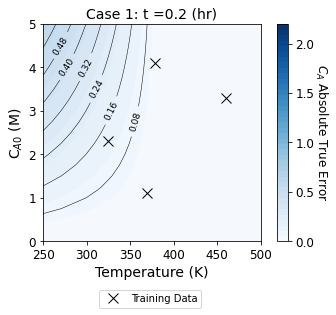

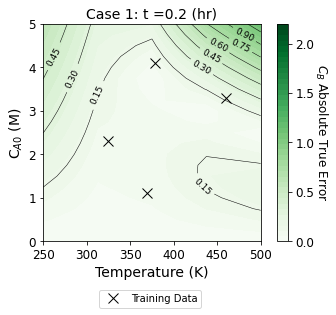

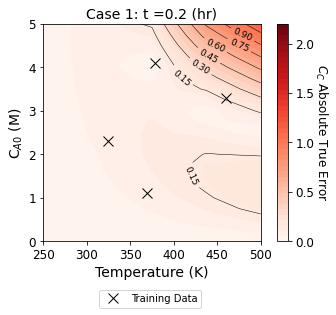

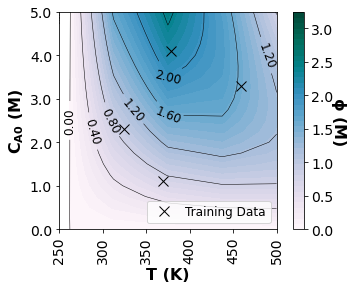

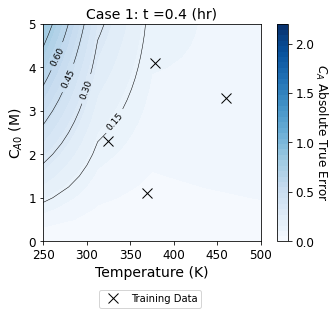

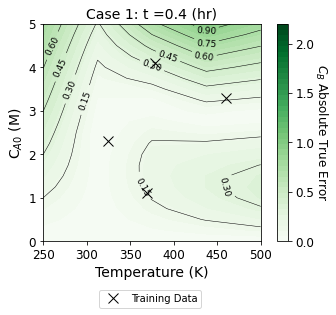

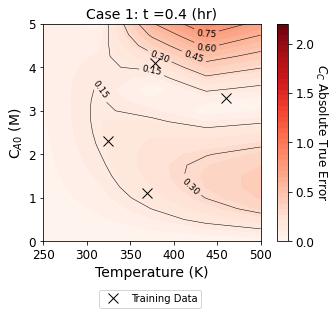

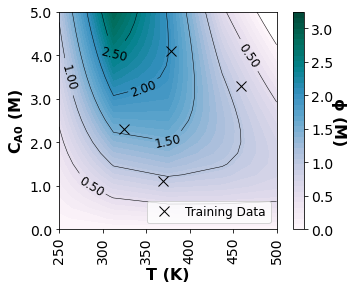

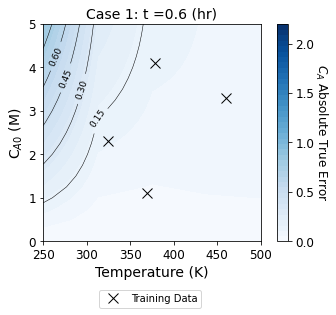

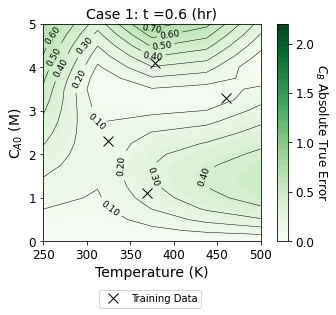

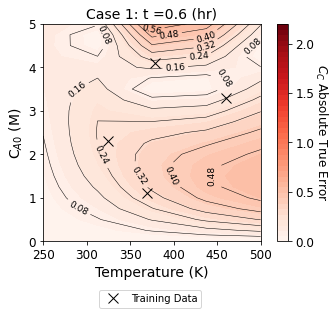

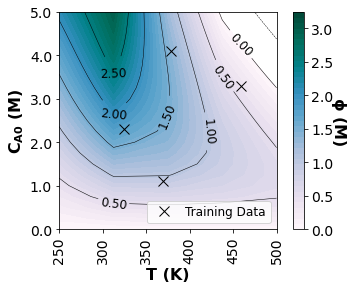

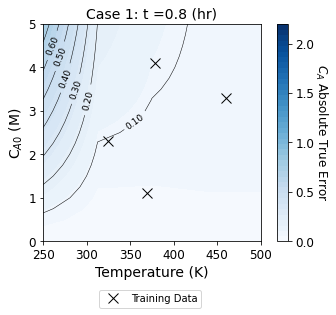

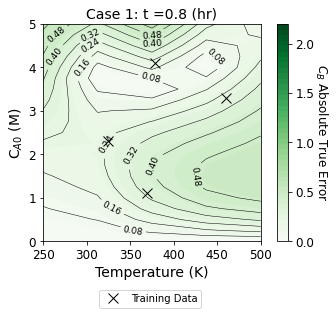

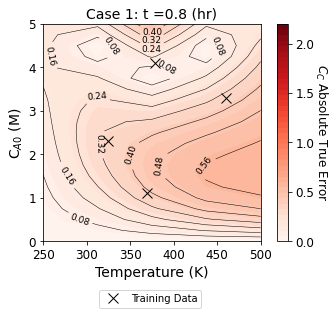

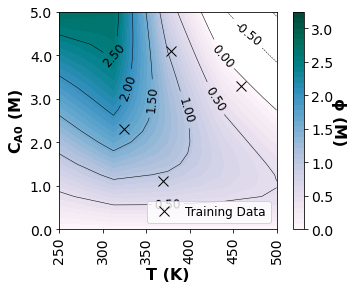

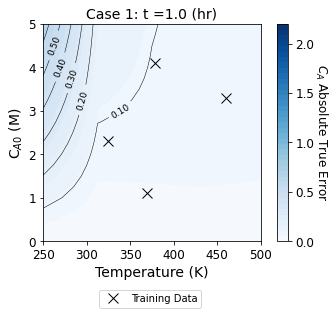

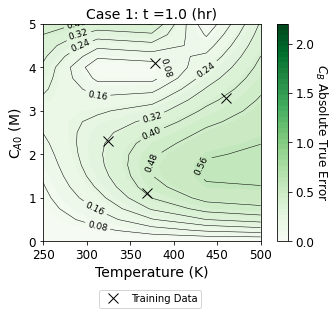

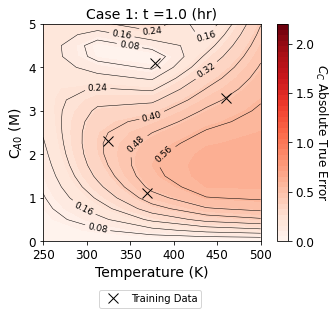

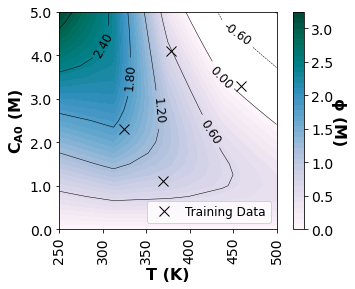

In [11]:
# set control variable ranges
T = np.linspace(250, 500, 5) # [K] temperature range of interest
CA0 = np.arange(0.001, 5.25, 0.25) # [M] starting concentration of A
t = np.linspace(0,1,51) # [hr] time
t_des = np.array([0.2,0.4,0.6,0.8,1]) # time we desire to study [hr]

# set full physics parameters
A_fp = np.array([200, 100, 50])
E_fp = np.array([10, 20, 15])
θ_fp = np.hstack([A_fp, E_fp])

# set simple physics parameters
case_no = 1 # set case number
θ_sp = paf.get_case_params(case_no, sp_params) # retrieve simple physics parameters for case of interest

# set objective weights
obj_weights = [-0.5,1,-0.5,0,0]
    
# initialize
err_A = initialize(CA0, T) # initialize an A error matrix
err_B = initialize(CA0, T) # initialize an B error matrix
err_C = initialize(CA0, T) # initialize an C error matrix
err_obj = initialize(CA0, T) # initialize an obj error matrix
obj_fp_plt = initialize(CA0, T)

for i in np.arange(0, len(t_des)): # loop over desired times
    
    for j in np.arange(0, len(CA0)): # loop over starting concentrations

        for k in np.arange(0, len(T)): # loop over temperatures

            # simulate full physics model
            CA_fp, CB_fp, CC_fp = rxn.full_physics_model_2(θ_fp, t, CA0[j], T[k])

            # simulate simple physics model
            CA_sp, CB_sp, CC_sp = rxn.simple_physics_model(θ_sp, t, CA0[j], T[k])
        
            # compute objective function for full physics
            obj_fp = paf.objective_function(CA_fp, CB_fp, CC_fp, t, T[k], obj_weights, print_level = 2, temp_ref = 500)
    
            # compute objective function for simple physics
            obj_sp = paf.objective_function(CA_sp, CB_sp ,CC_sp, t, T[k], obj_weights, print_level = 2, temp_ref = 500)
        
            # extract time of interest
            idx = find_idx(t, t_des[i])

            # compute error between full and simple physics models at desired times
            err_A[j,k] = abs_tru_err(CA_fp[idx], CA_sp[idx])
            err_B[j,k] = abs_tru_err(CB_fp[idx], CB_sp[idx])
            err_C[j,k] = abs_tru_err(CC_fp[idx], CC_sp[idx])
            err_obj[j,k] = abs_tru_err(obj_fp[idx], obj_sp[idx])
            obj_fp_plt[j,k] = obj_fp[idx]
            
        # extract experiments from case study number
        case_exp_set = get_exps(case_no, exp_list)

        # something here
        CA0_td = np.zeros(4)
        T_td = np.zeros(4)
        
        # extract control variables from exp_set
        for j in np.arange(0,len(case_exp_set)):
            case_ctrl_vars = controls.loc[controls['exp']== case_exp_set[j]].to_numpy()
            T_td[j] = case_ctrl_vars[0,2]
            CA0_td[j] = case_ctrl_vars[0,3]
            
    # create contour plots
    contour_plot(T, CA0, err_A,'A', T_td, CA0_td, case_no, t_des[i])
    contour_plot(T, CA0, err_B,'B', T_td, CA0_td, case_no, t_des[i])
    contour_plot(T, CA0, err_C,'C', T_td, CA0_td, case_no, t_des[i])
    obj_contour_plot_fp(T, CA0, obj_fp_plt, T_td, CA0_td, case_no, t_des[i])

In [7]:
# def temp_conc(T,CA0,t,t_des, θ_fp, case_no, θ_sp):
    
#     err_A = np.zeros([len(CA0),len(T)]) # initialize error matrix
#     err_B = np.zeros([len(CA0),len(T)]) # initialize error matrix
    
#     for i in np.arange(0, len(CA0)):

#         for j in np.arange(0, len(T)):

#             # simulate full physics model
#             CA_fp, CB_fp, CC_fp = rxn.full_physics_model_2(θ_fp, t, CA0[i], T[j])

#             # simulate simple physics model
#             CA_sp, CB_sp, CC_sp = rxn.simple_physics_model(θ_sp, t, CA0[i], T[j])

#             # extract time of interest
#             err = t - t_des
#             obj = min(abs(err))
#             idx = int(np.where(err == obj)[0])

#             # compute error between full and simple physics models at desired times
#             err_A[i,j] = abs((CA_fp[idx] - CA_sp[idx])
#             err_B[i,j] = abs((CB_fp[idx] - CB_sp[idx])
            
#             #err_B[i,j] = abs((CB_sp[idx] - CB_fp[idx])/CB_fp[idx])


#     # extract experiments from case study number
#     case_exp_set = exp_list.loc[exp_list['case'] == case_no].to_numpy()
#     case_exp_set = case_exp_set[0,1:5]
#     CA0_td = np.zeros(4)
#     T_td = np.zeros(4)

#     # extract control variables from exp_set
#     for j in np.arange(0,len(case_exp_set)):
#         case_ctrl_vars = controls.loc[controls['exp']== case_exp_set[j]].to_numpy()
#         T_td[j] = case_ctrl_vars[0,2]
#         CA0_td[j] = case_ctrl_vars[0,3]


#     # make grid of sample points for plotting
#     # test_points = pd.DataFrame(list(itertools.product(T,CA0)), columns = ('temp','conc'))

#     # now we need to plot the CB_err as a function of temperature and time
#     fig = plt.figure(1)
#     ax = fig.add_subplot(111)
    
#     levels = np.arange(0, 1.01, 0.01)
#     plt.contourf(T, CA0, err_B, cmap = 'Greens',  levels = levels)


#     plt.plot(test_points['temp'], test_points['conc'],'o', markerfacecolor = None, markeredgecolor ='g', markersize = 1, label = r'Test Points')


#     plt.plot(T_td, CA0_td, 'kx', markersize = 8, label = r'Training Data')
#     plt.legend(fontsize = '12')
#     ax.legend(bbox_to_anchor=(0.75, -0.2))
#     plt.clim(0,1)
#     cbar = plt.colorbar(ticks = np.arange(0, 1.2, 0.2))
#     cbar.ax.tick_params(labelsize = 12)
#     cbar.ax.get_yaxis().labelpad = 15
#     cbar.ax.set_ylabel(r'Absolute True Error', rotation = 270, fontsize = 12)

#     X, Y = np.meshgrid(T, CA0)
#     CS = plt.contour(X, Y, err_B, colors = 'k', linewidths = 1)
#     ax.clabel(CS, fontsize = 9, inline = 1, fmt = '%1.2f')

#     plt.title(r'Case '+str(case_no)+r': t ='+str(t_des)+r' (hr)', fontsize = 14)
#     plt.xlabel(r'Temperature (K)', fontsize = 14)
#     plt.ylabel(r'C$_{A0}$ (M)', fontsize = 14)
#     plt.tick_params(labelsize = 12)
#     plt.ylim(0,5)
#     ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
               
#     cwd = os.getcwd()
#     path_to_fig = os.path.join(cwd, 'concentration_temp_maps', 'case_'+str(case_no))
#     file_name = 'fig_'+str(t_des)+'_case_'+str(case_no)+'.png'
#     fig.savefig(os.path.join(path_to_fig, file_name), bbox_inches='tight', dpi= 1200)

In [16]:
# the giant lazy guy you wrote
# def temp_conc(T,CA0,t,t_des, θ_fp, case_no, θ_sp):
    
#     err_A = np.zeros([len(CA0),len(T)]) # initialize A error matrix
#     err_B = np.zeros([len(CA0),len(T)]) # initialize B error matrix
#     err_C = np.zeros([len(CA0),len(T)]) # initialize C error matrix
    
#     for i in np.arange(0, len(CA0)):

#         for j in np.arange(0, len(T)):

#             # simulate full physics model
#             CA_fp, CB_fp, CC_fp = rxn.full_physics_model_2(θ_fp, t, CA0[i], T[j])

#             # simulate simple physics model
#             CA_sp, CB_sp, CC_sp = rxn.simple_physics_model(θ_sp, t, CA0[i], T[j])

#             # extract time of interest
#             err = t - t_des
#             obj = min(abs(err))
#             idx = int(np.where(err == obj)[0])

#             # compute error between full and simple physics models at desired times
#             err_A[i,j] = abs(CA_fp[idx] - CA_sp[idx])
#             err_B[i,j] = abs(CB_fp[idx] - CB_sp[idx])
#             err_C[i,j] = abs(CC_fp[idx] - CC_sp[idx])

            
#     # extract experiments from case study number
#     case_exp_set = exp_list.loc[exp_list['case'] == case_no].to_numpy()
#     case_exp_set = case_exp_set[0,1:5]
#     CA0_td = np.zeros(4)
#     T_td = np.zeros(4)

#     # extract control variables from exp_set
#     for j in np.arange(0,len(case_exp_set)):
#         case_ctrl_vars = controls.loc[controls['exp']== case_exp_set[j]].to_numpy()
#         T_td[j] = case_ctrl_vars[0,2]
#         CA0_td[j] = case_ctrl_vars[0,3]

#     vmin = 0
#     vmax = 2.2
#     levels = np.linspace(vmin, vmax, 41)
#     dv= 0.2
    
#     # now we need to plot the CA_err as a function of temperature and time
#     fig = plt.figure(1)
#     ax = fig.add_subplot(111)
    
#     plt.contourf(T, CA0, err_A, cmap = 'Blues', levels = levels)
#     plt.plot(T_td, CA0_td, 'kx', markersize = 10, label = r'Training Data')
#     plt.legend(fontsize = '12')
#     ax.legend(bbox_to_anchor=(0.75, -0.2))
    
#     cbar = plt.colorbar(ticks = np.arange(vmin, vmax + 0.5, 0.5))
#     plt.clim(vmin, vmax)
#     cbar.ax.tick_params(labelsize = 12)
#     cbar.ax.get_yaxis().labelpad = 15
#     cbar.ax.set_ylabel(r'$C_A$ Absolute True Error', rotation = 270, fontsize = 12)
    
#     X, Y = np.meshgrid(T, CA0)
#     CS = plt.contour(X, Y, err_A, colors = 'k', linewidths = 0.5) #, levels= levels)
#     ax.clabel(CS, fontsize = 9, inline = 1, fmt = '%1.2f')
    
#     plt.title(r'Case '+str(case_no)+r': t ='+str(t_des)+r' (hr)', fontsize = 14)
#     plt.xlabel(r'Temperature (K)', fontsize = 14)
#     plt.ylabel(r'C$_{A0}$ (M)', fontsize = 14)
#     plt.tick_params(labelsize = 12)
#     plt.ylim(0,5)
#     ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#     plt.show()
    
#     cwd = os.getcwd()
#     path_to_fig = os.path.join(cwd, 'concentration_temp_maps', 'case_'+str(case_no))
#     file_name = 'CA_fig_'+str(t_des)+'_case_'+str(case_no)+'.png'
#     fig.savefig(os.path.join(path_to_fig, file_name), bbox_inches='tight', dpi= 1200)
        
#     # now we need to plot the CB_err as a function of temperature and time
#     fig = plt.figure(2)
#     ax = fig.add_subplot(111)

#     plt.contourf(T, CA0, err_B, cmap = 'Greens', levels = levels)
#     plt.plot(T_td, CA0_td, 'kx', markersize = 10, label = r'Training Data')
#     plt.legend(fontsize = '12')
#     ax.legend(bbox_to_anchor=(0.75, -0.2))
#     plt.clim(vmin,vmax)
#     cbar = plt.colorbar(ticks = np.arange(vmin, vmax + 0.5, 0.5))
#     cbar.ax.tick_params(labelsize = 12)
#     cbar.ax.get_yaxis().labelpad = 15
#     cbar.ax.set_ylabel(r'$C_B$ Absolute True Error', rotation = 270, fontsize = 12)

#     X, Y = np.meshgrid(T, CA0)
#     CS = plt.contour(X, Y, err_B, colors = 'k', linewidths = 0.5)
#     ax.clabel(CS, fontsize = 9, inline = 1, fmt = '%1.2f')

#     plt.title(r'Case '+str(case_no)+r': t ='+str(t_des)+r' (hr)', fontsize = 14)
#     plt.xlabel(r'Temperature (K)', fontsize = 14)
#     plt.ylabel(r'C$_{A0}$ (M)', fontsize = 14)
#     plt.tick_params(labelsize = 12)
#     plt.ylim(0,5)
#     ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#     plt.show()
    
#     cwd = os.getcwd()
#     path_to_fig = os.path.join(cwd, 'concentration_temp_maps', 'case_'+str(case_no))
#     file_name = 'CB_fig_'+str(t_des)+'_case_'+str(case_no)+'.png'
#     fig.savefig(os.path.join(path_to_fig, file_name), bbox_inches='tight', dpi= 1200)
       
#     # now we need to plot the CC_err as a function of temperature and time
#     fig = plt.figure(3)
#     ax = fig.add_subplot(111)
    
#     plt.contourf(T, CA0, err_C, cmap = 'Reds', levels = levels)
#     plt.plot(T_td, CA0_td, 'kx', markersize = 10, label = r'Training Data')
#     plt.legend(fontsize = '12')
#     ax.legend(bbox_to_anchor=(0.75, -0.2))
#     plt.clim(vmin,vmax)
#     cbar = plt.colorbar(ticks = np.arange(vmin, vmax + 0.5, 0.5))
#     cbar.ax.tick_params(labelsize = 12)
#     cbar.ax.get_yaxis().labelpad = 15
#     cbar.ax.set_ylabel(r'$C_C$ Absolute True Error', rotation = 270, fontsize = 12)

#     X, Y = np.meshgrid(T, CA0)
#     CS = plt.contour(X, Y, err_C, colors = 'k', linewidths = 0.5) # levels = levels)
#     ax.clabel(CS, fontsize = 9, inline = 1, fmt = '%1.2f')

#     plt.title(r'Case '+str(case_no)+r': t ='+str(t_des)+r' (hr)', fontsize = 14)
#     plt.xlabel(r'Temperature (K)', fontsize = 14)
#     plt.ylabel(r'C$_{A0}$ (M)', fontsize = 14)
#     plt.tick_params(labelsize = 12)
#     plt.ylim(0,5)
#     ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#     plt.show()                 
                             
#     cwd = os.getcwd()
#     path_to_fig = os.path.join(cwd, 'concentration_temp_maps', 'case_'+str(case_no))
#     file_name = 'CC_fig_'+str(t_des)+'_case_'+str(case_no)+'.png'
#     fig.savefig(os.path.join(path_to_fig, file_name), bbox_inches='tight', dpi= 1200)

In [17]:
#this works
# T = np.linspace(250, 500, 5) # temperature range of interest
# CA0 = np.arange(0.001, 5.25, 0.25) # [M] starting concentration of A
# t = np.linspace(0,1,51) # [hr] time
# t_des = np.array([0.2,0.4,0.6,0.8,1]) # time we desire to study [hr]

# # set full physics parameters
# A_fp = np.array([200, 100, 50])
# E_fp = np.array([10, 20, 15])
# θ_fp = np.hstack([A_fp, E_fp])
# print(θ_fp)

# # get parameters for case of interest
# case_no = 10
# θ_sp = paf.get_case_params(case_no, sp_params)

# for i in np.arange(0, len(t_des)):
#     temp_conc(T,CA0,t,t_des[i], θ_fp, case_no, θ_sp)

In [10]:
# def gen_test_pts(T, CA0):
#     # inputs: control variables
#         # T = 1d np.array, input temperature 
#         # CA0 = 1d np.array,  starting concentration
#     # returns: test grid
#         # test_grid: pandas data frame, grid of test points for every possible combination of CA0 and T 
#     test_points = pd.DataFrame(list(itertools.product(T,CA0)), columns = ('temp','conc'))
#     return test_points

In [11]:
# # define control variables
# T = np.linspace(250, 500, 5) # temperature range of interest
# CA0 = np.arange(0.001, 5.25, 0.25) # [M] starting concentration of A
# t = np.array([0.2,0.4,0.6,0.8,1]) # time we desire to study [hr]

# # set full physics parameters
# A_fp = np.array([200, 100, 50]) # full physics pre-exponential factor
# E_fp = np.array([10, 20, 15]) # full physics activation energy
# θ_fp = np.hstack([A_fp, E_fp]) # full physics parameters

# # get parameters for case of interest
# case_no = 10 # case to be ran
# θ_sp = paf.get_case_params(case_no, sp_params) # simple physics parameters

# # generate grid of test points
# test_points = gen_test_pts(T, CA0)
# display(test_points)

# dict = {}
# # simulate models over entire test grid
# CA_fp = np.zeros([len(t),len(test_points.temp),])
# print(CA_fp)
# for j in np.arange(0,len(test_points.temp)):
    
#     CA_fp[:,j], CB_fp[:,j], CC_fp[:,j] = rxn.full_physics_model_2(θ_fp, t, test_points.conc[j], test_points.temp[j])
    
   # data = {'CA_fp':CA_fp[j], 'CB_fp':CB_fp[j], 'CC_fp':CC_fp[j]}
   # df = pd.DataFrame(data)
   # display(df[j])
    
    
    #for i in np.arange(0,len(t)):
    # create a dictionary of data frames for each time for all points in the grid
    #    key = 'case_'+str(case_no)+'_time_'+str(t[i])
    #    data = {'CA0':[test_points.conc[j]], 'T':[test_points.temp[j]] ,'CA_fp':[CA_fp[i]], 'CB_fp':[CB_fp[i]], 'CC_fp':[CC_fp[i]]}
    #    df = pd.DataFrame(data)
        
    #    display(df)
    #   dict[key] = df

    #print(CA_fp)
   #break
# simulate simple physics model
#CA_sp, CB_sp, CC_sp = rxn.simple_physics_model(θ_sp, t, CA0[i], T[j])